In [ ]:
import pandas as pd
import os
import numpy as np
import random 
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/project_data

/content/drive/My Drive/project_data


In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/project_data/train_data.csv')
data = train_data.copy()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
label = data['loan_status']
data = data.drop(['loan_status'], axis = 1)

for i in range(len(label)):
    if label[i] == 'Charged Off':
        label[i] = 1
    else:
        label[i] = 0

import sklearn.model_selection as model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, label, train_size=0.7,test_size=0.3, random_state=101, stratify = label)

In [ ]:
def data_preprocessing(data, miss_threshold, category):
    '''
    Data: dataframe type original data
    miss_threhold: float type, determine whether keep the feature
    category: boolean type, determine whether keep categoical data
    '''
    if category == False: 
        categorical = []
        for name in data.columns:
            for x in data[name][data[name].isna() == False]:
                if type(x) != str:
                    categorical.append(name)
                    break
        data = data[categorical]
                
    
    data = data[[x for x in data.columns if (sum(data[x].isna())/len(data)) <= miss_threshold]]
    unchanged_feature = [x for x in data.columns if len(data[x].unique()) == 1]
    data = data.drop(unchanged_feature, axis = 1)
    
    return data

In [ ]:
miss_threshold = 0.25
category = False
X_train = data_preprocessing(X_train, miss_threshold, category)

In [ ]:
def categorical_check(df, threshold):
    non_cate = []
    for x in df.columns:
        if len(df[x].unique()) >= threshold:
            non_cate.append(x)
            
    return df[non_cate]

In [ ]:
threshold = 100
numerical = categorical_check(X_train, threshold)
numerical3 = numerical.drop(['recoveries', 'out_prncp', 'out_prncp_inv', 'collection_recovery_fee'], axis = 1)
numerical_test3 = X_test[numerical3.columns]

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=100, random_state=0)

y_train = np.array(y_train.astype(int))
y_test = np.array(y_test.astype(int))

mice_imp_x = imp.fit_transform(numerical3, y = y_train)
mice_imp_x_test = imp.fit(numerical3, y = y_train).transform(numerical_test3)

In [ ]:
from xgboost import XGBClassifier
from numpy import mean

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


xgb = XGBClassifier(colsample_bytree = 0.7, learning_rate=0.5,max_depth=5, 
                          scale_pos_weight= 1, eval_metric = 'auc', n_estimator = 300)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
# evaluate model
scores = cross_val_score(xgb, mice_imp_x, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.977


In [ ]:
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint


max_depth = [int(x) for x in np.linspace(5, 30, num = 4)]


random_grid = {
               'max_depth': max_depth, 
               }

xgb = XGBClassifier(nthreads = -1, scale_pos_weight = 1, colsample_bytree = 0.7, n_estimators = 300)
pprint(random_grid)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state= 5)

{'max_depth': [5, 13, 21, 30]}


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

xgb = XGBClassifier(colsample_bytree = 0.7, learning_rate=0.5, max_depth= 20, 
                    scale_pos_weight= 1,  eval_metric = 'auc', n_estimator = 300)

pred = xgb.fit(mice_imp_x, y_train).predict_proba(mice_imp_x_test)

fpr, tpr, thresholds = roc_curve(y_test, pred[:,1])

auc(fpr, tpr)

0.9910348305066298

In [ ]:
xgb = XGBClassifier(colsample_bytree = 0.7, learning_rate=0.5, max_depth= 20, 
                    scale_pos_weight= 1,  eval_metric = 'auc', n_estimator = 300)

pred = xgb.fit(mice_imp_x, y_train).predict(mice_imp_x_test)

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

metrics.auc(fpr, tpr)

0.910639255511409

In [ ]:
xgb = XGBClassifier(colsample_bytree = 0.7, learning_rate=0.5, max_depth= 20, 
                    scale_pos_weight= 1,  eval_metric = 'auc', n_estimator = 300)

pred = xgb.fit(mice_imp_x, y_train).predict(mice_imp_x)

fpr, tpr, thresholds = metrics.roc_curve(y_train, pred)

metrics.auc(fpr, tpr)

1.0

In [ ]:
# xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')

# xgb_random.fit(mice_imp_x, y_train)


In [ ]:
xgb_random.best_score_

Normalized confusion matrix
[[9.99295387e-01 7.04613447e-04]
 [1.78016876e-01 8.21983124e-01]]


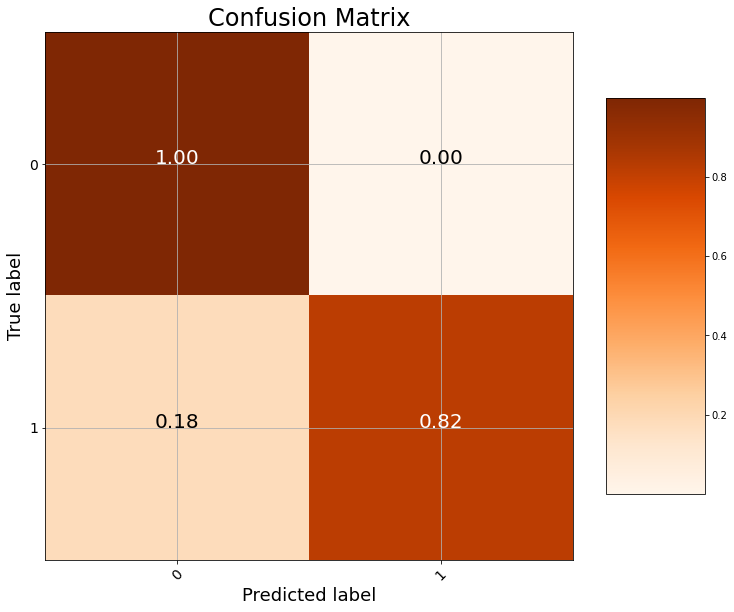

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes = ['0', '1'], normalize = True, 
                      title = 'Confusion Matrix')

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)


In [ ]:
pred = xgb.fit(mice_imp_x, y_train).predict_proba(mice_imp_x_test)